## EDA

### 概要

- 目的変数：2019年12月の各店舗における売上数
- 評価関数：RMSE（Root Mean Squared Error）

### 期限

- 10月6日

### カラム情報
<img src="カラム情報1.png">
<img src="カラム情報2.png">
<img src="カラム情報3.png">

### 検討が必要な事項

- 分類を絞る
- 12月のデータに何か重み付けをする
- 価格帯で分類する
- k-means法で分類する
- 発売から何日経過しているか
- 売上個数がマイナスのデータの扱い方
- 高額商品の扱い方
- 月ごとの売上数
- イベントの特徴量
- 新商品の価格
- バリエーションの方法→最初の期間から時系列順にクロスバリテーションを行う
- 最新の価格は最小値を置くか、平均を取るか
- 時期に応じて価格が変動しているか？

### 分析で判明したこと

- 売上がマイナスになっている商品が12アイテム存在する
- 販売数や売上個数は映画・音楽の割合が多いが売り上げで見るとゲーム（特にゲーム機CとPCゲーム）が締める割合が多い
- 店舗間の売上はかなり差がある（１位とビリで約３倍）
- ただ売れている商品の構成割合はそこまで大きな差はない（１位の方がゲームCの割合が若干多いくらい）
- 12月は売上におけるゲームの構成割合が増加する
- ゲームに関しては価格帯と売上個数で相関は見られない
- テストデータの113商品は過去に実績がない商品

In [92]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import gc
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [93]:
import matplotlib as mpl
mpl.matplotlib_fname()

'/Users/kanekotakafumi/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [94]:
path = "../input/"

df_category_names = pd.read_csv(path + 'category_names.csv')
df_item_categories = pd.read_csv(path + 'item_categories.csv')
df_sales_history = pd.read_csv(path + 'sales_history.csv')
df_sample_submission = pd.read_csv(path + 'sample_submission.csv')
df_test = pd.read_csv(path + 'test.csv')

<br>
<p>カテゴリー名はIDと各カテゴリーの名称がふられている。</p>
<p>25カテゴリー存在する模様。</p>
<p>販売実績データにマージして使用する。</p>

In [95]:
df_category_names

,商品カテゴリID,商品カテゴリ名
0,100,映画 - DVD
1,110,PCゲーム - 通常版
2,120,音楽 - その他
3,130,ゲーム - ゲーム機C
4,140,映画 - ブルーレイ
5,150,ゲーム - ゲーム機B
6,160,ギフト - 小型ゲーム
7,170,ギフト - カード、パズル等
8,180,ギフト - フィギュア
9,190,PCソフト - PCソフト


<br>
<p>これは各商品IDがどのカテゴリーに属しているかを示している模様。</p>

In [96]:
df_item_categories.head()

,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100


In [97]:
df_item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   商品ID      9426 non-null   int64
 1   商品カテゴリID  9426 non-null   int64
dtypes: int64(2)
memory usage: 147.4 KB


<br>
<p>9426アイテム存在する。</p>

In [98]:
print(f"マージ前{len(df_item_categories)}")
df_item_categories = pd.merge(df_item_categories, df_category_names, on="商品カテゴリID", how="inner")
print(f"マージ後{len(df_item_categories)}")

マージ前9426
マージ後9426


In [99]:
df_item_categories

,商品ID,商品カテゴリID,商品カテゴリ名
0,1000001,100,映画 - DVD
1,1000002,100,映画 - DVD
2,1000003,100,映画 - DVD
3,1000004,100,映画 - DVD
4,1000005,100,映画 - DVD
...,...,...,...
9421,3500072,350,本 - オーディオブック_タイプB
9422,3500073,350,本 - オーディオブック_タイプB
9423,3500074,350,本 - オーディオブック_タイプB
9424,3500075,350,本 - オーディオブック_タイプB


In [100]:
df_item_categories["商品カテゴリ名_大分類"] = df_item_categories["商品カテゴリ名"].str.extract('(.+) -', expand=True)

<AxesSubplot:xlabel='商品カテゴリ名_大分類', ylabel='count'>

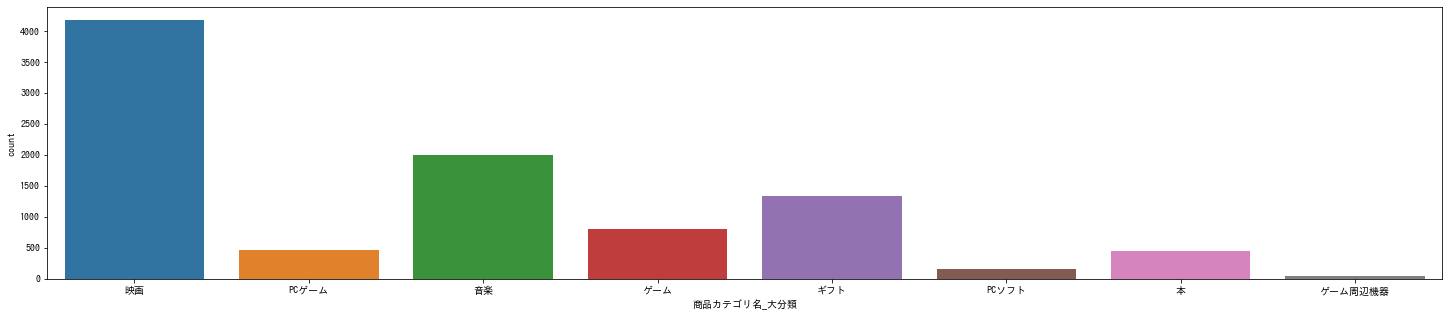

In [101]:
plt.figure(figsize=(25, 5))
sns.countplot(df_item_categories["商品カテゴリ名_大分類"])

<br>
<p>商品種類はゲームではなく映画、音楽が大半を締める模様。</p>
<p>ただゲームは詳細にカテゴリーが分かれているので、それが原因のようにも見える。</p>

In [102]:
tmp = df_item_categories.groupby("商品カテゴリ名", as_index=False)["商品ID"].count().\
      rename(columns={"商品ID":"商品種類"}).sort_values("商品種類", ascending=False)

tmp["構成比"] = tmp["商品種類"] / tmp["商品種類"].sum()

tmp

,商品カテゴリ名,商品種類,構成比
16,映画 - DVD,2733,0.289943
24,音楽 - その他,1379,0.146297
18,映画 - ブルーレイ,1049,0.111288
0,PCゲーム - 通常版,456,0.048377
12,ゲーム - ゲーム機C,383,0.040632
25,音楽 - レコード,354,0.037556
5,ギフト - フィギュア,304,0.032251
20,本 - オーディオブック_タイプA,281,0.029811
11,ゲーム - ゲーム機B,267,0.028326
23,音楽 - CD,259,0.027477


<br>
<p>上記のカテゴリの粒度をどの程度にするかは検討の余地がありそう。</p>
<p>続いて売上個数のデータ。</p>

In [103]:
df_sales_history.head()

,日付,店舗ID,商品ID,商品価格,売上個数
0,2018-01-01,9,1000001,420,1.0
1,2018-01-01,6,1000001,420,1.0
2,2018-01-01,10,1000001,420,1.0
3,2018-01-01,0,1000017,250,1.0
4,2018-01-01,1,1000017,250,1.0


In [104]:
df_sales_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   日付      1119570 non-null  object 
 1   店舗ID    1119570 non-null  int64  
 2   商品ID    1119570 non-null  int64  
 3   商品価格    1119570 non-null  int64  
 4   売上個数    1119570 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.7+ MB


In [105]:
df_sales_history["日付"] = pd.to_datetime(df_sales_history["日付"], format='%Y-%m-%d')
df_sales_history["年月"] = df_sales_history["日付"].dt.strftime('%Y-%m')
df_sales_history["年"] = df_sales_history["日付"].dt.year
df_sales_history["月"] = df_sales_history["日付"].dt.month
df_sales_history["日"] = df_sales_history["日付"].dt.day

df_sales_history["売上"] = df_sales_history["売上個数"] * df_sales_history["商品価格"]

print(f"マージ前{len(df_sales_history)}")
df_sales_history = pd.merge(df_sales_history, df_item_categories ,on="商品ID", how="inner")
print(f"マージ後{len(df_sales_history)}")

マージ前1119570
マージ後1119570


In [106]:
print(df_sales_history["年月"].unique())

['2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07'
 '2018-08' '2018-09' '2018-10' '2018-11' '2018-12' '2019-01' '2019-02'
 '2019-03' '2019-04' '2019-05' '2019-06' '2019-07' '2019-08' '2019-09'
 '2019-10']


In [107]:
sales_trends = df_sales_history.groupby("年月", as_index=False).agg({"商品ID":"count", "売上個数": "sum", "売上":"sum"})
sales_trends = sales_trends.rename(columns={"商品ID":"販売回数"})

In [108]:
sales_trends[["販売回数", "売上個数", "売上"]].describe()

,販売回数,売上個数,売上
count,22.000000,22.000000,2.200000e+01
mean,50889.545455,57403.136364,6.263289e+07
std,9899.411660,12165.737859,1.515600e+07
min,34331.000000,37570.000000,4.424690e+07
25%,42352.750000,46285.500000,5.075647e+07
50%,50452.500000,57219.500000,5.988452e+07
75%,55897.500000,63749.000000,7.043506e+07
max,76408.000000,89168.000000,1.090816e+08


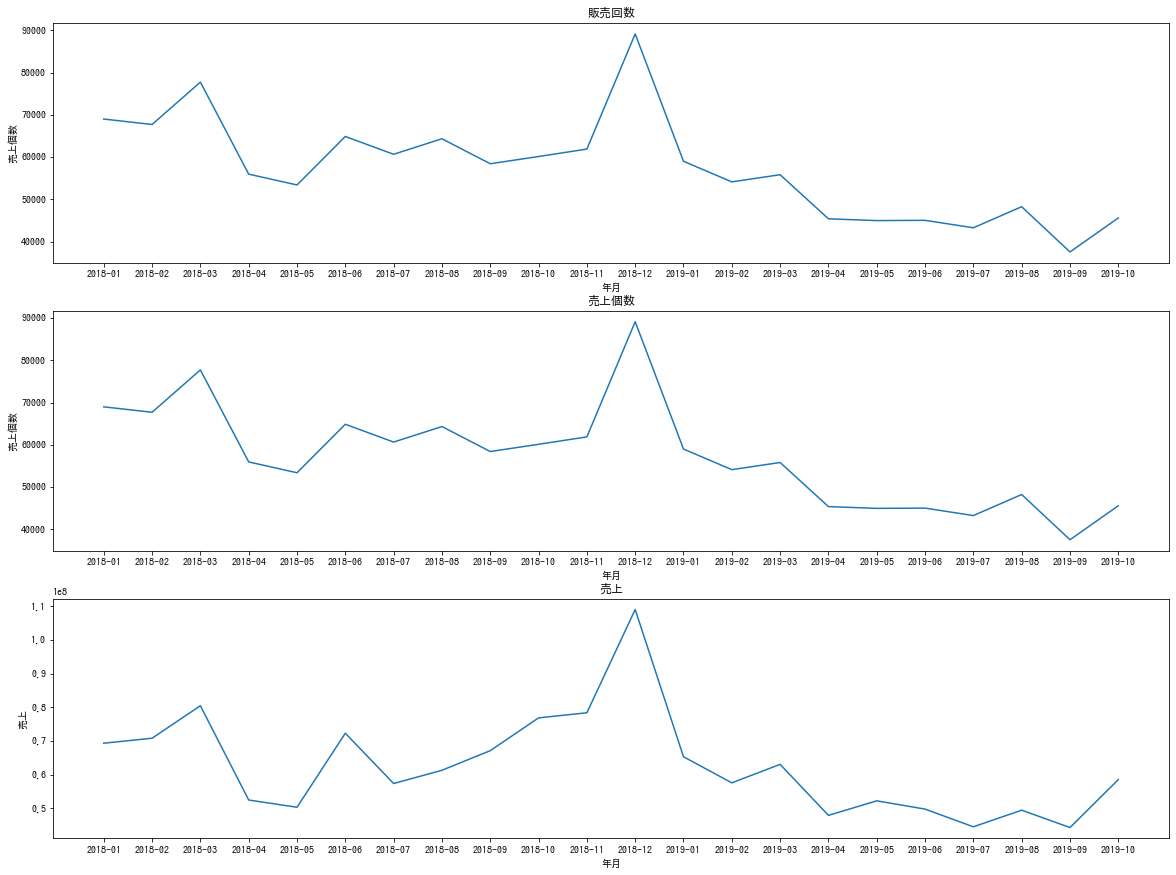

In [109]:
f,ax=plt.subplots(3,1,figsize=(20,15))
sns.lineplot(x="年月", y="売上個数", data=sales_trends , ax=ax[0])
ax[0].set_title('販売回数')
sns.lineplot(x="年月", y="売上個数", data=sales_trends , ax=ax[1])
ax[1].set_title('売上個数')
sns.lineplot(x="年月", y="売上", data=sales_trends , ax=ax[2])
ax[2].set_title('売上')
plt.show()

In [110]:
sales_trends_y_m = df_sales_history.groupby(["年","月"], as_index=False).agg({"商品ID":"count", "売上個数": "sum", "売上":"sum"}).\
                   rename(columns={"商品ID":"販売回数"})
sales_trends_m = sales_trends_y_m.groupby(["月"], as_index=False).agg({"販売回数":"mean", "売上個数": "mean", "売上":"mean"})
sales_trends_m[["販売回数", "売上個数", "売上"]].describe()

,販売回数,売上個数,売上
count,12.000000,12.000000,1.200000e+01
mean,52035.791667,58914.708333,6.522414e+07
std,9172.190108,11297.302448,1.647318e+07
min,42767.500000,48009.000000,5.015214e+07
25%,45766.500000,51669.125000,5.431345e+07
50%,50002.750000,55648.500000,6.259297e+07
75%,54724.125000,62445.000000,6.869708e+07
max,76408.000000,89168.000000,1.090816e+08


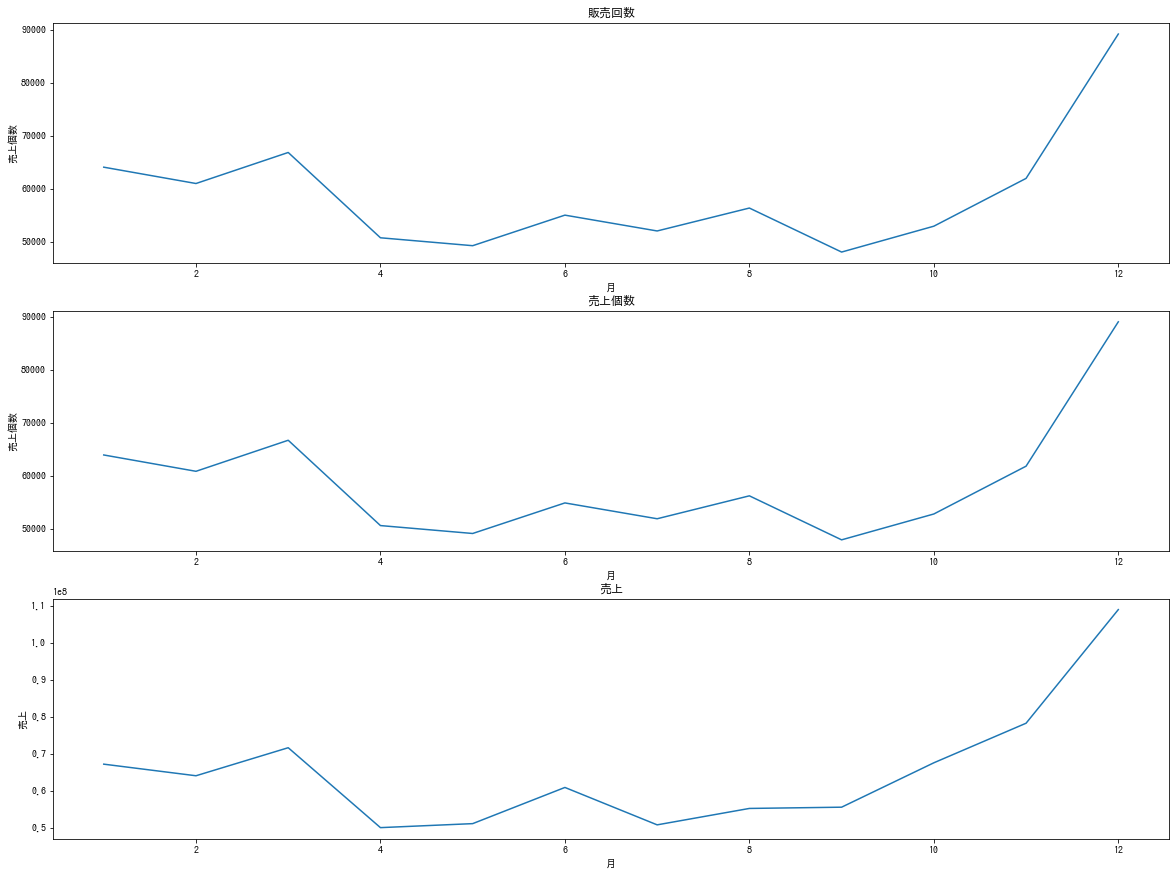

In [111]:
f,ax=plt.subplots(3,1,figsize=(20,15))
sns.lineplot(x="月", y="売上個数", data=sales_trends_m , ax=ax[0])
ax[0].set_title('販売回数')
sns.lineplot(x="月", y="売上個数", data=sales_trends_m , ax=ax[1])
ax[1].set_title('売上個数')
sns.lineplot(x="月", y="売上", data=sales_trends_m , ax=ax[2])
ax[2].set_title('売上')
plt.show()

In [129]:
sales_trends_category = df_sales_history.groupby(["商品カテゴリ名_大分類" ,"商品カテゴリ名"], as_index=False).agg({"商品ID":"count", "売上個数": "sum", "売上":"sum"}).\
                        rename(columns={"商品ID":"販売回数"}).sort_values("売上", ascending=False)

sales_trends_category["売上構成"] = sales_trends_category["売上"] / sales_trends_category["売上"].sum()
sales_trends_category["平均単価"] = sales_trends_category["売上"] / sales_trends_category["売上個数"]
sales_trends_category

,商品カテゴリ名_大分類,商品カテゴリ名,販売回数,売上個数,売上,売上構成,平均単価
12,ゲーム,ゲーム - ゲーム機C,104075,127512.0,343156360.0,0.249039,2691.169145
0,PCゲーム,PCゲーム - 通常版,165554,204775.0,165646630.0,0.120215,808.920181
11,ゲーム,ゲーム - ゲーム機B,57543,65304.0,152257450.0,0.110498,2331.517977
16,映画,映画 - DVD,260515,293135.0,130881250.0,0.094984,446.487966
24,音楽,音楽 - その他,160674,165089.0,79729640.0,0.057862,482.949439
1,PCソフト,PCソフト - PCソフト,21652,24741.0,75725740.0,0.054956,3060.738855
18,映画,映画 - ブルーレイ,89226,94123.0,73728170.0,0.053507,783.317255
5,ギフト,ギフト - フィギュア,19801,21968.0,44451140.0,0.032260,2023.449563
17,映画,映画 - セット商品,17356,18029.0,32632460.0,0.023682,1809.998336
19,映画,映画 - ブルーレイ3D,20605,21746.0,32131690.0,0.023319,1477.590821


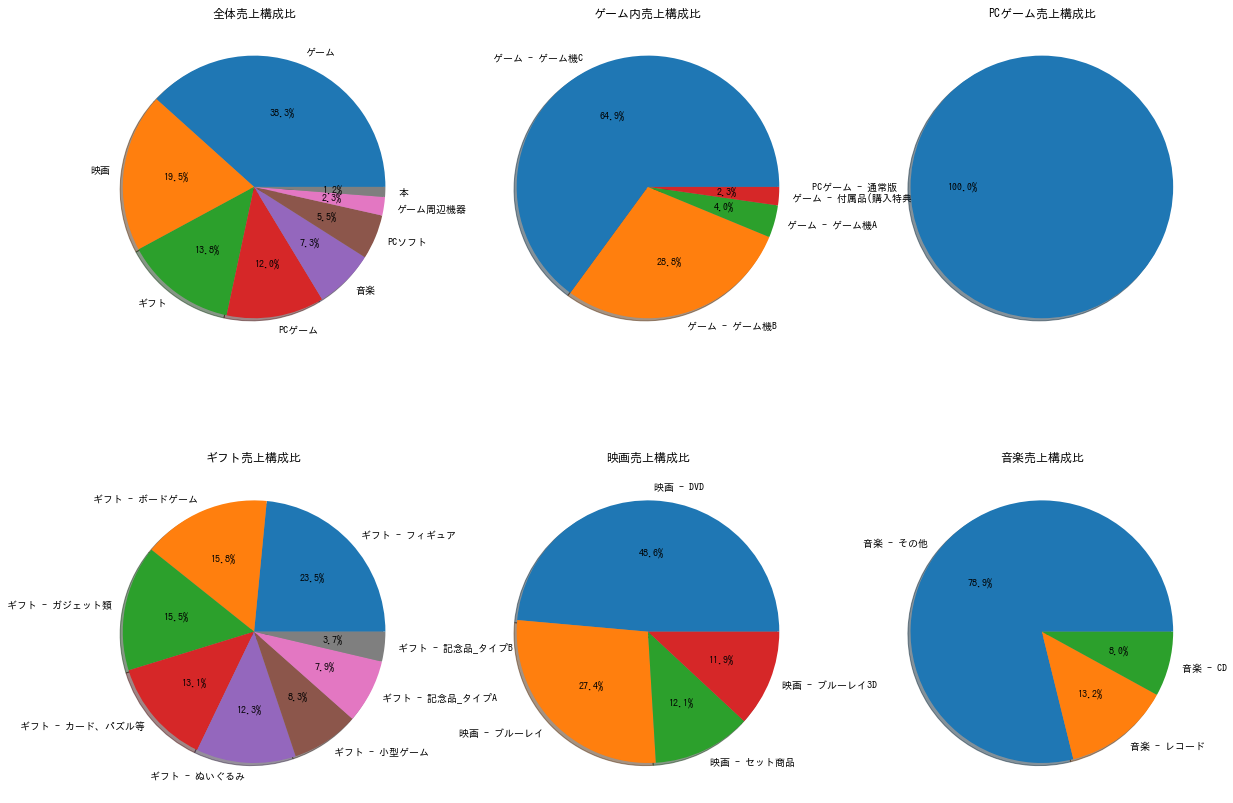

In [142]:
f,ax=plt.subplots(2,3,figsize=(20,15))
tmp = sales_trends_category.groupby("商品カテゴリ名_大分類", as_index=False)["売上"].sum().sort_values("売上", ascending=False)
ax[0,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名_大分類"],autopct='%1.1f%%',shadow=True)
ax[0,0].set_title('全体売上構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="ゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,1].set_title('ゲーム内売上構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="PCゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,2].set_title('PCゲーム売上構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="ギフト"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,0].set_title('ギフト売上構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="映画"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,1].set_title('映画売上構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="音楽"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,2].set_title('音楽売上構成比')
plt.show()

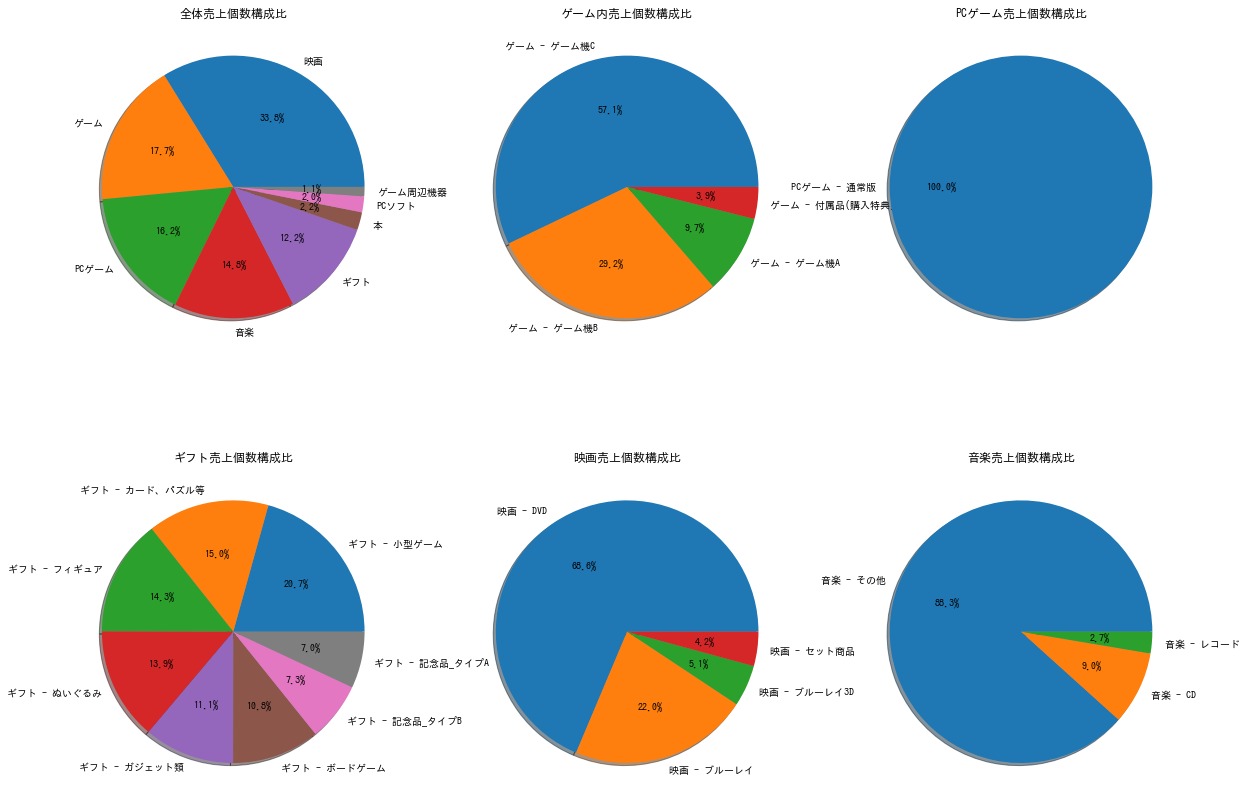

In [144]:
f,ax=plt.subplots(2,3,figsize=(20,15))
tmp = sales_trends_category.groupby("商品カテゴリ名_大分類", as_index=False)["売上個数"].sum().sort_values("売上個数", ascending=False)
ax[0,0].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名_大分類"],autopct='%1.1f%%',shadow=True)
ax[0,0].set_title('全体売上個数構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="ゲーム"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[0,1].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,1].set_title('ゲーム内売上個数構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="PCゲーム"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[0,2].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,2].set_title('PCゲーム売上個数構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="ギフト"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[1,0].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,0].set_title('ギフト売上個数構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="映画"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[1,1].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,1].set_title('映画売上個数構成比')

tmp = sales_trends_category[sales_trends_category["商品カテゴリ名_大分類"]=="音楽"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[1,2].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,2].set_title('音楽売上個数構成比')
plt.show()

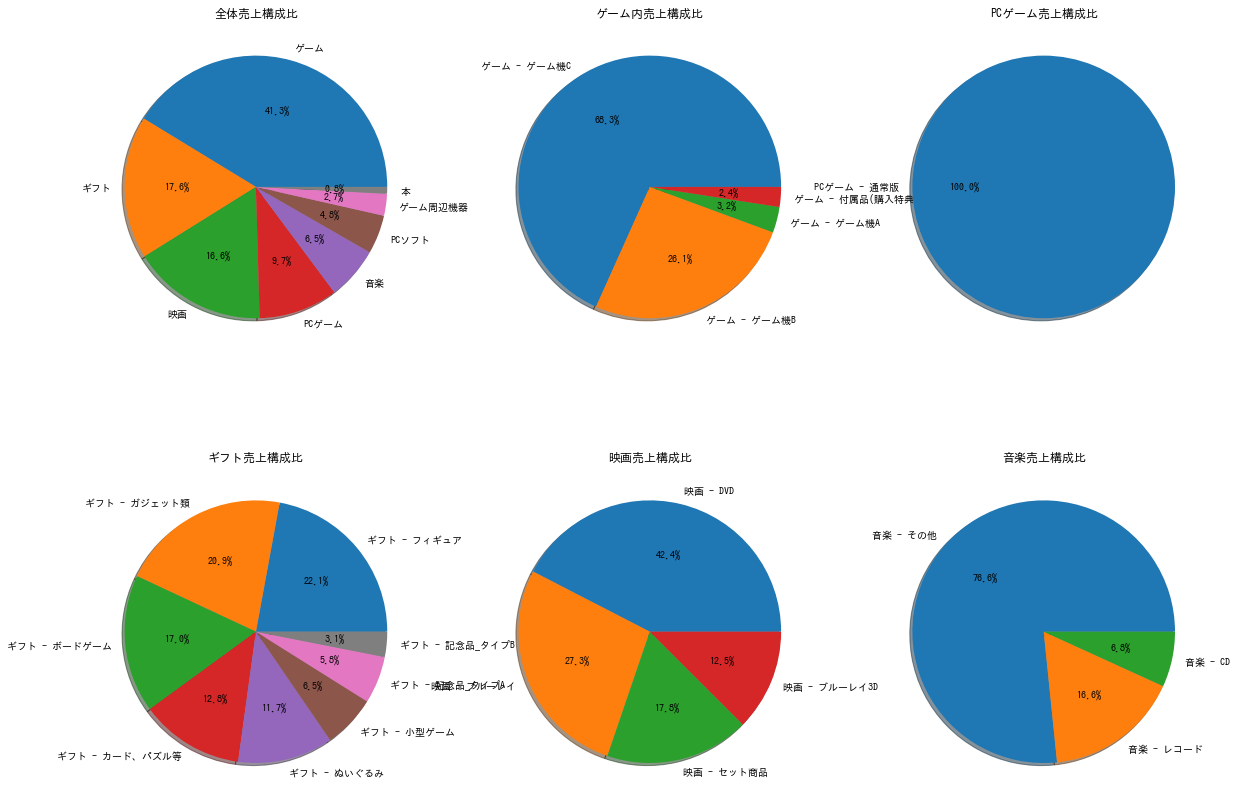

In [147]:
f,ax=plt.subplots(2,3,figsize=(20,15))
sales_trends_category_dec = df_sales_history[df_sales_history["月"]==12].groupby(["商品カテゴリ名_大分類" ,"商品カテゴリ名"], as_index=False).\
                            agg({"商品ID":"count", "売上個数": "sum", "売上":"sum"}).rename(columns={"商品ID":"販売回数"}).sort_values("売上", ascending=False)

tmp = sales_trends_category_dec.groupby("商品カテゴリ名_大分類", as_index=False)["売上"].sum().sort_values("売上", ascending=False)
ax[0,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名_大分類"],autopct='%1.1f%%',shadow=True)
ax[0,0].set_title('全体売上構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="ゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,1].set_title('ゲーム内売上構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="PCゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,2].set_title('PCゲーム売上構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="ギフト"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,0].set_title('ギフト売上構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="映画"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,1].set_title('映画売上構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="音楽"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,2].set_title('音楽売上構成比')
plt.show()

<br>
<p>やはり12月になるとゲームが占める割合が増加する。</p>
<p>また、ゲーム内の割合もゲーム機Cが占める割合が多くなる。</p>

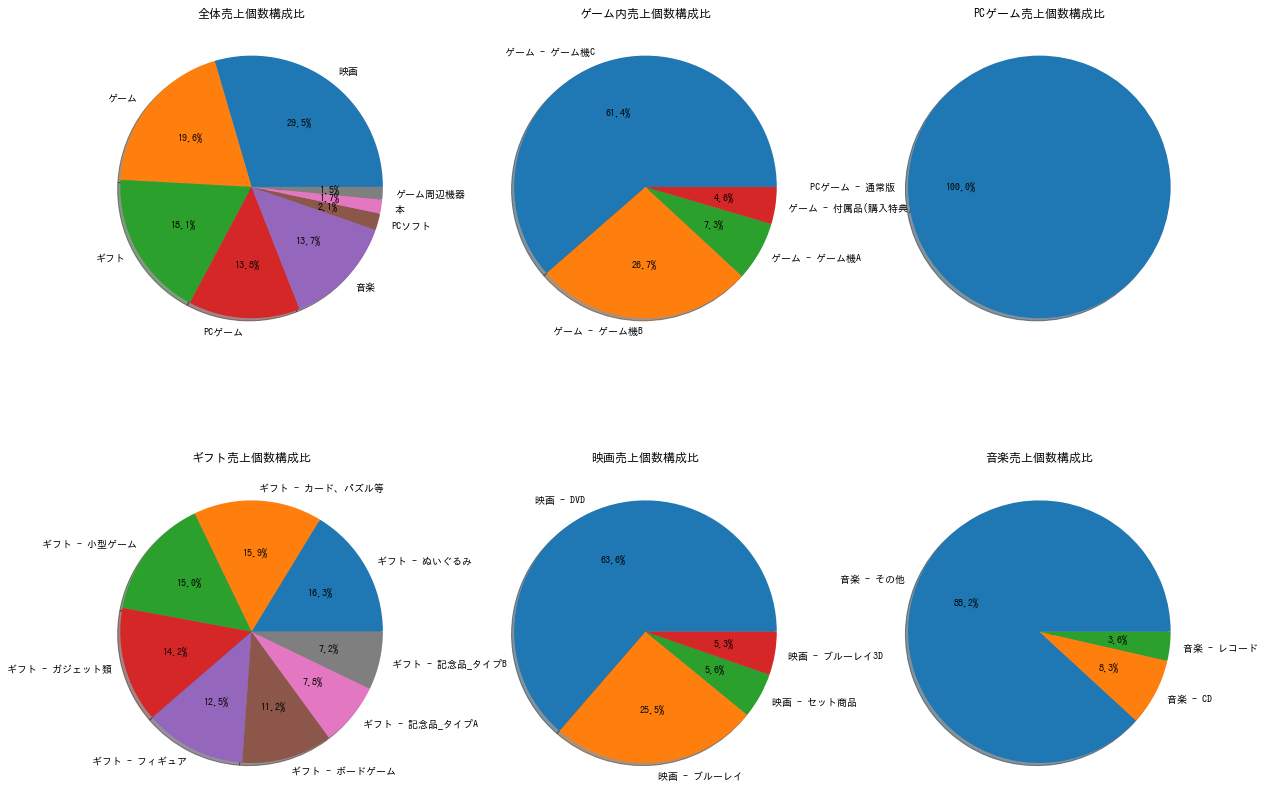

In [146]:
f,ax=plt.subplots(2,3,figsize=(20,15))
sales_trends_category_dec = df_sales_history[df_sales_history["月"]==12].groupby(["商品カテゴリ名_大分類" ,"商品カテゴリ名"], as_index=False).\
                            agg({"商品ID":"count", "売上個数": "sum", "売上":"sum"}).rename(columns={"商品ID":"販売回数"}).sort_values("売上", ascending=False)

tmp = sales_trends_category_dec.groupby("商品カテゴリ名_大分類", as_index=False)["売上個数"].sum().sort_values("売上個数", ascending=False)
ax[0,0].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名_大分類"],autopct='%1.1f%%',shadow=True)
ax[0,0].set_title('全体売上個数構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="ゲーム"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[0,1].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,1].set_title('ゲーム内売上個数構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="PCゲーム"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[0,2].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,2].set_title('PCゲーム売上個数構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="ギフト"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[1,0].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,0].set_title('ギフト売上個数構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="映画"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[1,1].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,1].set_title('映画売上個数構成比')

tmp = sales_trends_category_dec[sales_trends_category_dec["商品カテゴリ名_大分類"]=="音楽"].groupby("商品カテゴリ名", as_index=False)["売上個数"].sum().\
      sort_values("売上個数", ascending=False)

ax[1,2].pie(tmp["売上個数"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,2].set_title('音楽売上個数構成比')
plt.show()

In [121]:
sales_trends_item = df_sales_history.groupby(["商品カテゴリ名_大分類", "商品カテゴリ名", "商品ID", "商品価格"], as_index=False).agg({"店舗ID":"count", "売上個数": "sum", "売上":"sum"}).\
                        rename(columns={"店舗ID":"販売回数"}).sort_values("売上", ascending=False)

sales_trends_item

,商品カテゴリ名_大分類,商品カテゴリ名,商品ID,商品価格,販売回数,売上個数,売上
10560,ゲーム,ゲーム - ゲーム機C,1300239,4420,3363,5245.0,23182900.0
10932,ゲーム,ゲーム - ゲーム機C,1300285,4420,1755,2625.0,11602500.0
11965,ゲーム周辺機器,ゲーム周辺機器 - ゲーム機B,3200004,2530,3127,3778.0,9558340.0
1846,PCゲーム,PCゲーム - 通常版,1100375,2040,2532,4652.0,9490080.0
2610,PCソフト,PCソフト - PCソフト,1900089,2700,2467,2959.0,7989300.0
...,...,...,...,...,...,...,...
27428,映画,映画 - ブルーレイ3D,2000022,3810,1,-1.0,-3810.0
9790,ゲーム,ゲーム - ゲーム機C,1300116,4400,1,-1.0,-4400.0
7171,ゲーム,ゲーム - ゲーム機B,1500021,3380,2,-2.0,-6760.0
21036,映画,映画 - セット商品,2300034,10180,1,-1.0,-10180.0


In [114]:
print(f'売上がマイナスになっているアイテム数{len(sales_trends_item[sales_trends_item["売上"]<0])}')

売上がマイナスになっているアイテム数12


In [127]:
sales_trends_item.describe()

,商品ID,商品価格,販売回数,売上個数,売上
count,3.429300e+04,34293.000000,34293.000000,34293.000000,3.429300e+04
mean,1.526393e+06,991.387455,32.647187,36.825854,4.018090e+04
std,6.088139e+05,3263.835457,116.637796,146.916608,2.551734e+05
min,1.000001e+06,0.000000,1.000000,-2.000000,-1.019000e+04
25%,1.002545e+06,250.000000,1.000000,1.000000,6.200000e+02
50%,1.300300e+06,510.000000,3.000000,4.000000,2.280000e+03
75%,1.800039e+06,1130.000000,15.000000,17.000000,1.298000e+04
max,3.500073e+06,523570.000000,4091.000000,5422.000000,2.318290e+07


In [190]:
sales_trends_item[sales_trends_item["商品価格"]>sales_trends_item["商品価格"].quantile(0.999)].sort_values("商品価格", ascending=False)

,商品カテゴリ名_大分類,商品カテゴリ名,商品ID,商品価格,販売回数,売上個数,売上
2750,PCソフト,PCソフト - PCソフト,1900119,523570,1,1.0,523570.0
2730,PCソフト,PCソフト - PCソフト,1900109,71400,1,1.0,71400.0
2382,PCソフト,PCソフト - PCソフト,1900026,62880,3,3.0,188640.0
2674,PCソフト,PCソフト - PCソフト,1900100,62880,1,1.0,62880.0
2381,PCソフト,PCソフト - PCソフト,1900026,61180,1,1.0,61180.0
2380,PCソフト,PCソフト - PCソフト,1900026,56080,3,3.0,168240.0
2673,PCソフト,PCソフト - PCソフト,1900100,55140,1,1.0,55140.0
2552,PCソフト,PCソフト - PCソフト,1900068,50490,1,1.0,50490.0
2780,PCソフト,PCソフト - PCソフト,1900135,44610,1,1.0,44610.0
2565,PCソフト,PCソフト - PCソフト,1900077,42330,1,1.0,42330.0


<Figure size 1440x720 with 0 Axes>

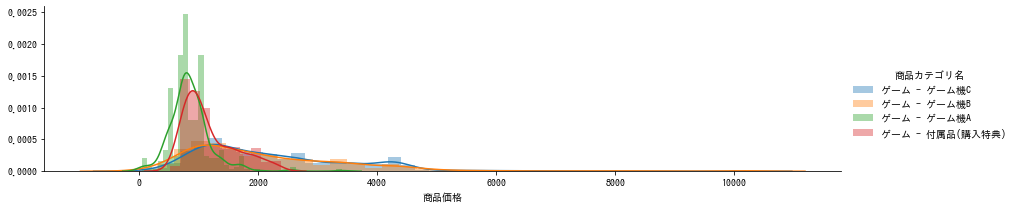

In [154]:
plt.figure(figsize=(20,10))
fig = sns.FacetGrid(sales_trends_item[sales_trends_item["商品カテゴリ名_大分類"]=="ゲーム"], hue='商品カテゴリ名', aspect=4)
fig.map(sns.distplot, '商品価格')
fig.add_legend()

<br>
<p>同じゲームでもゲーム機に応じて大きく価格帯は異なる。</p>

<AxesSubplot:xlabel='商品価格', ylabel='Density'>

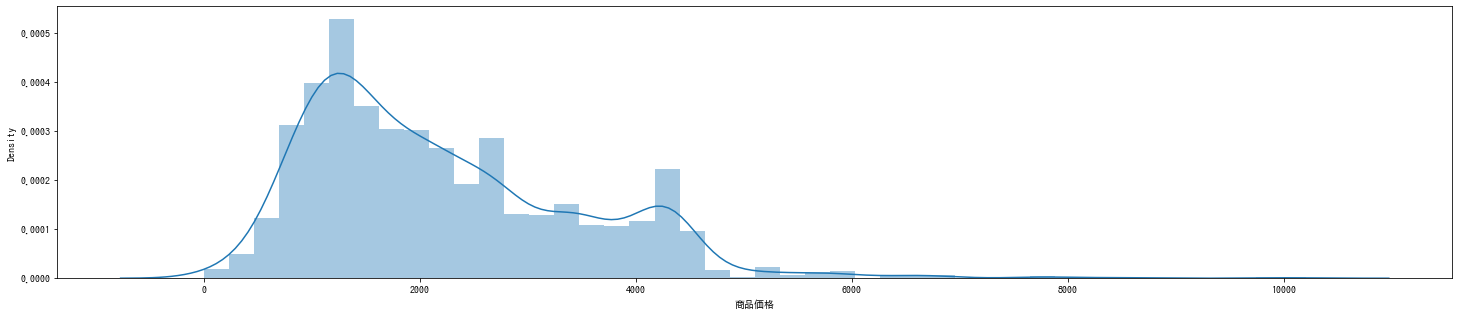

In [148]:
plt.figure(figsize=(25, 5))
sns.distplot(sales_trends_item[sales_trends_item["商品カテゴリ名"]=="ゲーム - ゲーム機C"]["商品価格"])

<AxesSubplot:xlabel='商品価格', ylabel='Density'>

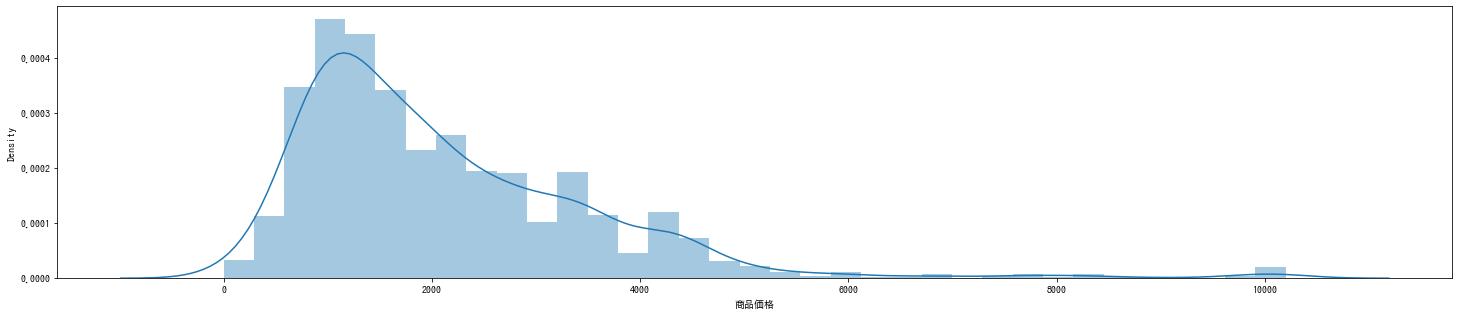

In [150]:
plt.figure(figsize=(25, 5))
sns.distplot(sales_trends_item[sales_trends_item["商品カテゴリ名"]=="ゲーム - ゲーム機B"]["商品価格"])

<AxesSubplot:xlabel='商品価格', ylabel='Density'>

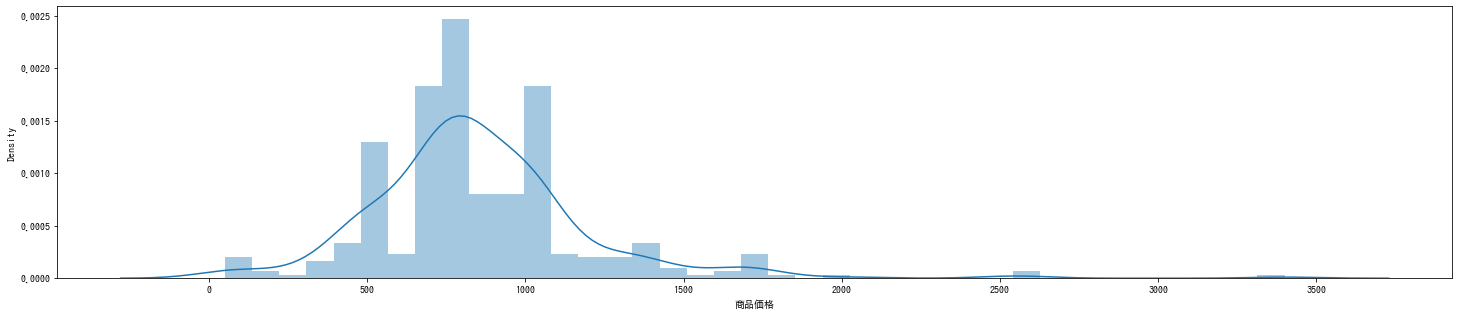

In [152]:
plt.figure(figsize=(25, 5))
sns.distplot(sales_trends_item[sales_trends_item["商品カテゴリ名"]=="ゲーム - ゲーム機A"]["商品価格"])

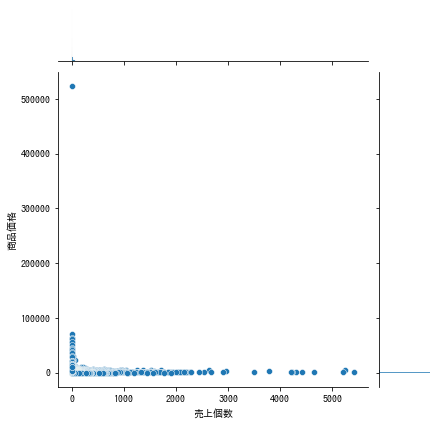

In [215]:
sns.jointplot('売上個数', '商品価格', data=sales_trends_item)

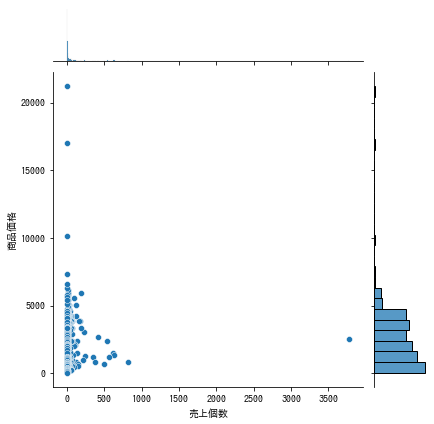

In [214]:
sns.jointplot('売上個数', '商品価格', data=sales_trends_item[sales_trends_item["商品カテゴリ名_大分類"]=="ゲーム周辺機器"])

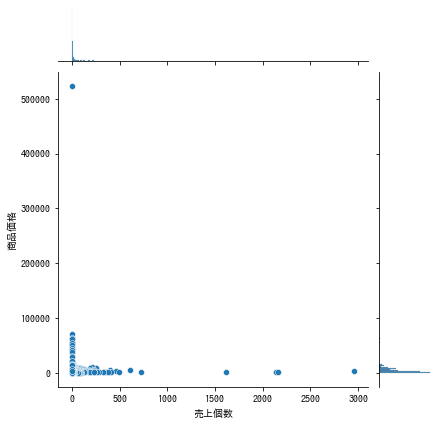

In [216]:
sns.jointplot('売上個数', '商品価格', data=sales_trends_item[sales_trends_item["商品カテゴリ名_大分類"]=="PCソフト"])

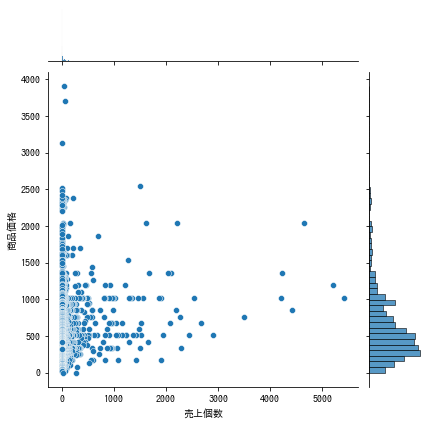

In [217]:
sns.jointplot('売上個数', '商品価格', data=sales_trends_item[sales_trends_item["商品カテゴリ名_大分類"]=="PCゲーム"])

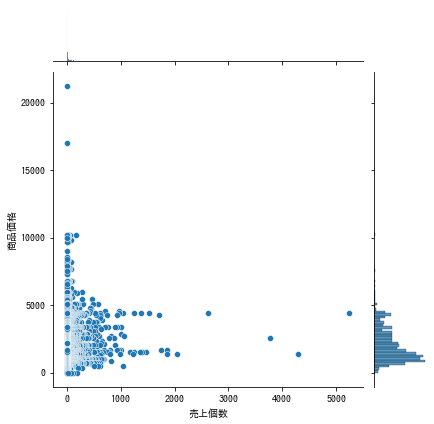

In [213]:
sns.jointplot('売上個数', '商品価格', data=sales_trends_item[sales_trends_item["商品カテゴリ名_大分類"].isin(["ゲーム","ゲーム周辺機器"])])

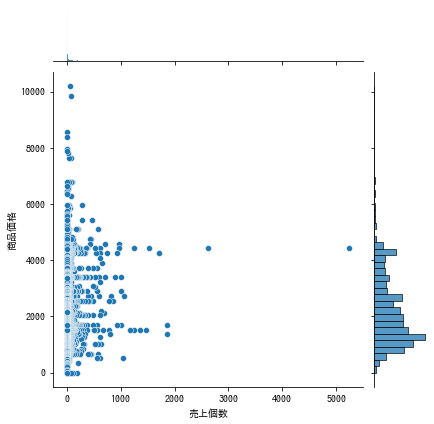

In [173]:
sns.jointplot('売上個数', '商品価格', data=sales_trends_item[sales_trends_item["商品カテゴリ名"]=="ゲーム - ゲーム機C"])

In [174]:
sales_trends_item

,商品カテゴリ名_大分類,商品カテゴリ名,商品ID,商品価格,販売回数,売上個数,売上
10560,ゲーム,ゲーム - ゲーム機C,1300239,4420,3363,5245.0,23182900.0
10932,ゲーム,ゲーム - ゲーム機C,1300285,4420,1755,2625.0,11602500.0
11965,ゲーム周辺機器,ゲーム周辺機器 - ゲーム機B,3200004,2530,3127,3778.0,9558340.0
1846,PCゲーム,PCゲーム - 通常版,1100375,2040,2532,4652.0,9490080.0
2610,PCソフト,PCソフト - PCソフト,1900089,2700,2467,2959.0,7989300.0
...,...,...,...,...,...,...,...
27428,映画,映画 - ブルーレイ3D,2000022,3810,1,-1.0,-3810.0
9790,ゲーム,ゲーム - ゲーム機C,1300116,4400,1,-1.0,-4400.0
7171,ゲーム,ゲーム - ゲーム機B,1500021,3380,2,-2.0,-6760.0
21036,映画,映画 - セット商品,2300034,10180,1,-1.0,-10180.0


In [157]:
df_sales_history["店舗ID"].nunique()

18

In [160]:
sales_trends_shop_cat = df_sales_history.groupby(["店舗ID","商品カテゴリ名_大分類" ,"商品カテゴリ名"], as_index=False).agg({"商品ID":"count", "売上個数": "sum", "売上":"sum"}).\
                        rename(columns={"商品ID":"販売回数"})

sales_trends_shop = sales_trends_shop_cat.groupby(["店舗ID"], as_index=False).agg({"販売回数":"sum", "売上個数": "sum", "売上":"sum"}).\
                    sort_values("売上", ascending=False)

In [161]:
sales_trends_shop

,店舗ID,販売回数,売上個数,売上
7,7,109137,124894.0,141890710.0
6,6,89987,102087.0,121778250.0
0,0,92108,107953.0,117872780.0
13,13,106734,125420.0,116414420.0
10,10,89012,102815.0,111612910.0
3,3,79017,87529.0,88036710.0
9,9,55205,67352.0,82536640.0
4,4,58743,64902.0,69864630.0
2,2,51841,56431.0,64820880.0
17,17,52231,56253.0,63614780.0


<br>
<p>かなり売上の差がある模様</p>

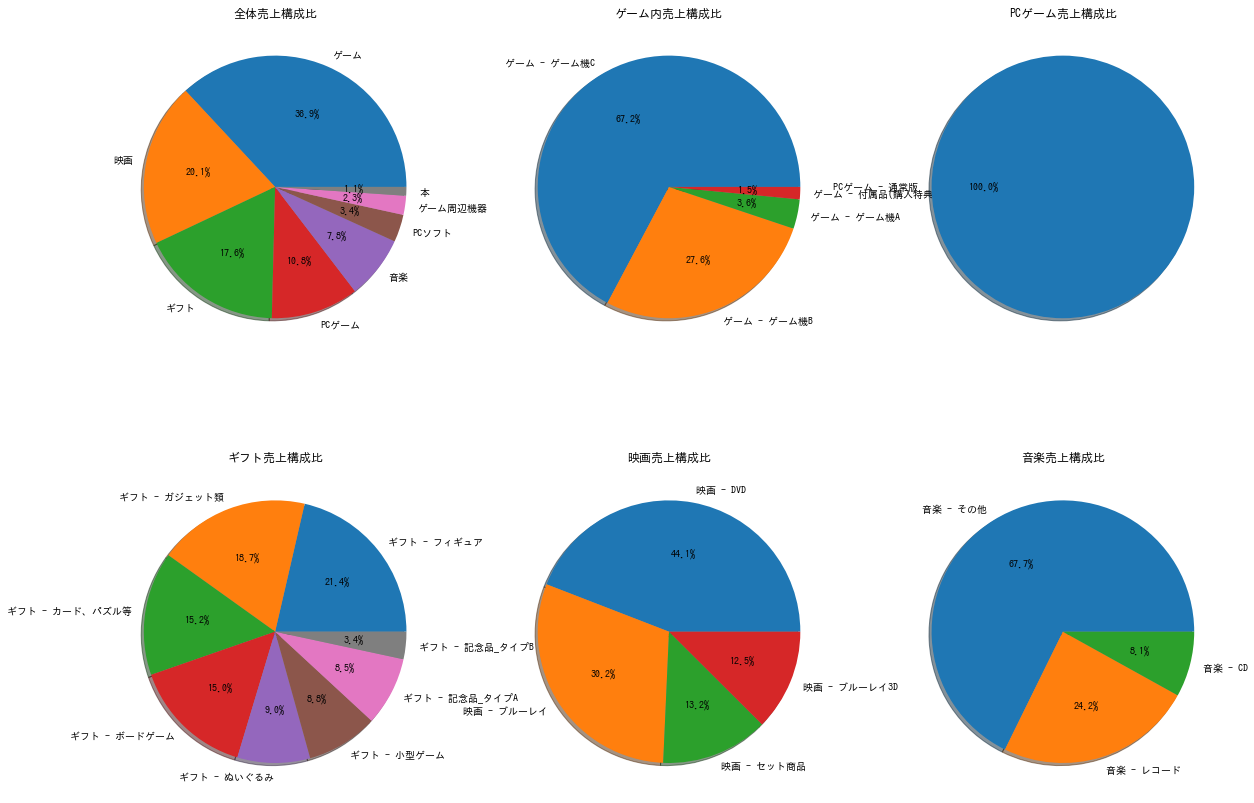

In [167]:
f,ax=plt.subplots(2,3,figsize=(20,15))

sales_trends_shop7_cat = sales_trends_shop_cat[sales_trends_shop_cat["店舗ID"]==7]

tmp = sales_trends_shop7_cat.groupby("商品カテゴリ名_大分類", as_index=False)["売上"].sum().sort_values("売上", ascending=False)
ax[0,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名_大分類"],autopct='%1.1f%%',shadow=True)
ax[0,0].set_title('全体売上構成比')

tmp = sales_trends_shop7_cat[sales_trends_shop7_cat["商品カテゴリ名_大分類"]=="ゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,1].set_title('ゲーム内売上構成比')

tmp = sales_trends_shop7_cat[sales_trends_shop7_cat["商品カテゴリ名_大分類"]=="PCゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,2].set_title('PCゲーム売上構成比')

tmp = sales_trends_shop7_cat[sales_trends_shop7_cat["商品カテゴリ名_大分類"]=="ギフト"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,0].set_title('ギフト売上構成比')

tmp = sales_trends_shop7_cat[sales_trends_shop7_cat["商品カテゴリ名_大分類"]=="映画"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,1].set_title('映画売上構成比')

tmp = sales_trends_shop7_cat[sales_trends_shop7_cat["商品カテゴリ名_大分類"]=="音楽"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,2].set_title('音楽売上構成比')
plt.show()

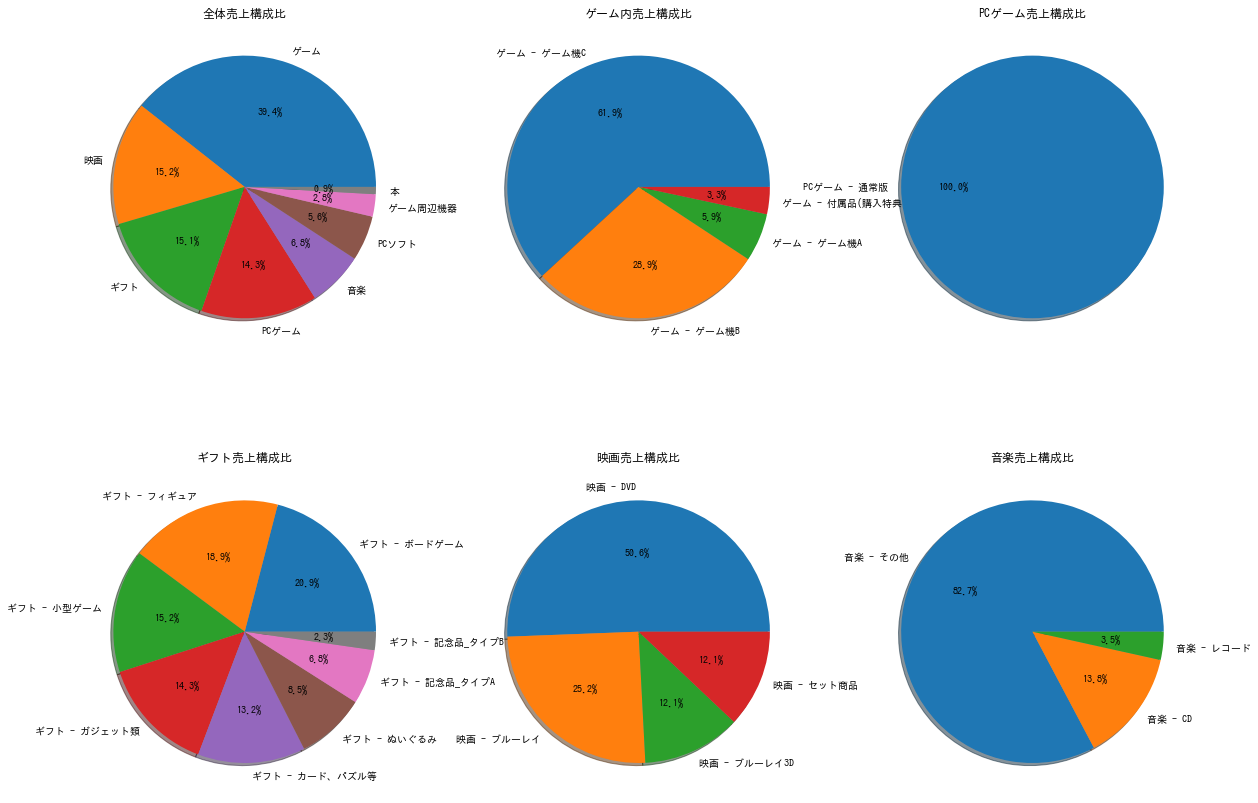

In [168]:
f,ax=plt.subplots(2,3,figsize=(20,15))

sales_trends_shop16_cat = sales_trends_shop_cat[sales_trends_shop_cat["店舗ID"]==16]

tmp = sales_trends_shop16_cat.groupby("商品カテゴリ名_大分類", as_index=False)["売上"].sum().sort_values("売上", ascending=False)
ax[0,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名_大分類"],autopct='%1.1f%%',shadow=True)
ax[0,0].set_title('全体売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="ゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,1].set_title('ゲーム内売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="PCゲーム"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[0,2].set_title('PCゲーム売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="ギフト"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,0].set_title('ギフト売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="映画"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,1].set_title('映画売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="音楽"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,2].set_title('音楽売上構成比')
plt.show()

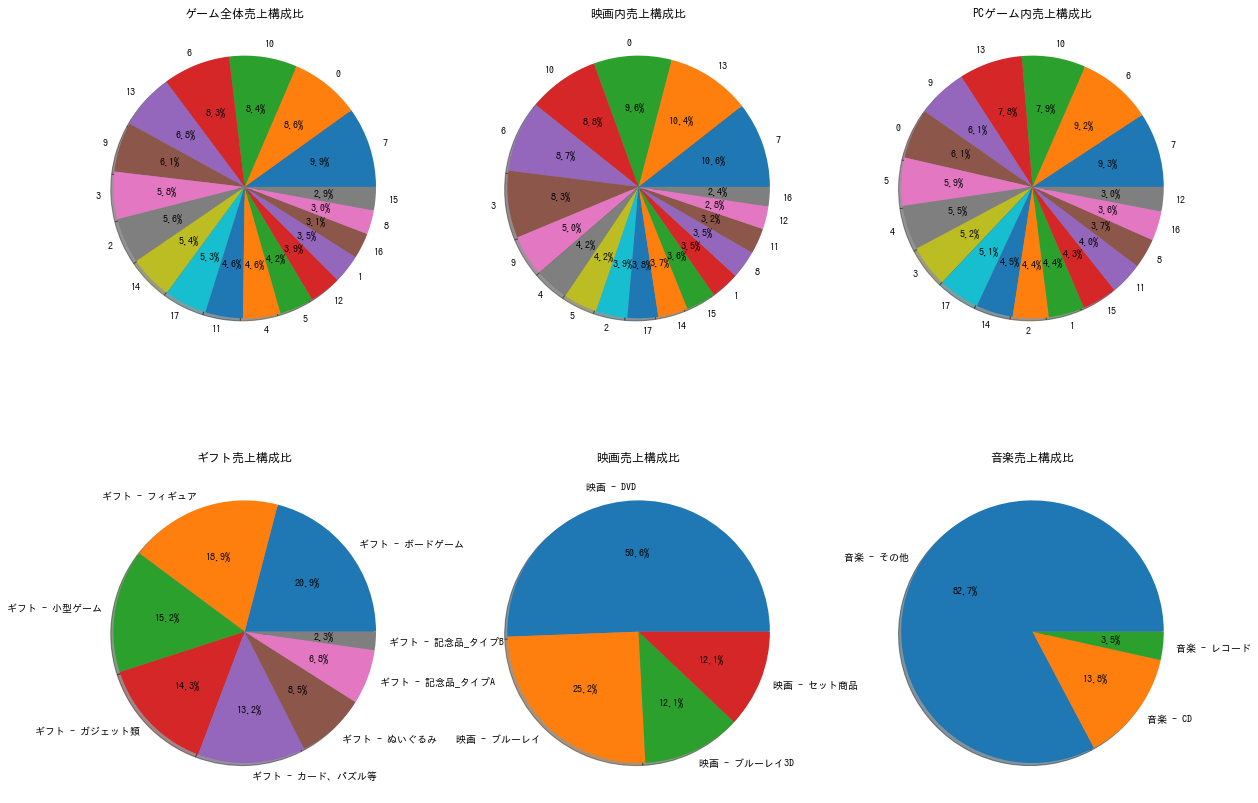

In [178]:
f,ax=plt.subplots(2,3,figsize=(20,15))


tmp = sales_trends_shop_cat[sales_trends_shop_cat["商品カテゴリ名_大分類"]=="ゲーム"].groupby("店舗ID", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,0].pie(tmp["売上"],labels=tmp["店舗ID"],autopct='%1.1f%%',shadow=True)
ax[0,0].set_title('ゲーム全体売上構成比')

tmp = sales_trends_shop_cat[sales_trends_shop_cat["商品カテゴリ名_大分類"]=="映画"].groupby("店舗ID", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,1].pie(tmp["売上"],labels=tmp["店舗ID"],autopct='%1.1f%%',shadow=True)
ax[0,1].set_title('映画内売上構成比')

tmp = sales_trends_shop_cat[sales_trends_shop_cat["商品カテゴリ名_大分類"]=="PCゲーム"].groupby("店舗ID", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[0,2].pie(tmp["売上"],labels=tmp["店舗ID"],autopct='%1.1f%%',shadow=True)
ax[0,2].set_title('PCゲーム内売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="ギフト"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,0].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,0].set_title('ギフト売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="映画"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,1].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,1].set_title('映画売上構成比')

tmp = sales_trends_shop16_cat[sales_trends_shop16_cat["商品カテゴリ名_大分類"]=="音楽"].groupby("商品カテゴリ名", as_index=False)["売上"].sum().\
      sort_values("売上", ascending=False)

ax[1,2].pie(tmp["売上"],labels=tmp["商品カテゴリ名"],autopct='%1.1f%%',shadow=True)
ax[1,2].set_title('音楽売上構成比')
plt.show()

In [184]:
df_test

,index,商品ID,店舗ID
0,0,1000001,0
1,1,1000001,1
2,2,1000001,2
3,3,1000001,3
4,4,1000001,4
...,...,...,...
3055,3055,3500001,13
3056,3056,3500001,14
3057,3057,3500001,15
3058,3058,3500001,16


In [182]:
item_list = df_test["商品ID"].unique()

len(sales_trends_item[sales_trends_item["商品ID"].isin(item_list)])

897

In [175]:
df_sample_submission

,0,100
0,1,100
1,2,100
2,3,100
3,4,100
4,5,100
...,...,...
3054,3055,100
3055,3056,100
3056,3057,100
3057,3058,100


<br>
<p>発売日を出す。</p>

In [183]:
df_sales_history.groupby("商品ID", )

,日付,店舗ID,商品ID,商品価格,売上個数,年月,年,月,日,売上,商品カテゴリID,商品カテゴリ名,商品カテゴリ名_大分類
0,2018-01-01,9,1000001,420,1.0,2018-01,2018,1,1,420.0,100,映画 - DVD,映画
1,2018-01-01,6,1000001,420,1.0,2018-01,2018,1,1,420.0,100,映画 - DVD,映画
2,2018-01-01,10,1000001,420,1.0,2018-01,2018,1,1,420.0,100,映画 - DVD,映画
3,2018-01-02,10,1000001,420,2.0,2018-01,2018,1,2,840.0,100,映画 - DVD,映画
4,2018-01-02,9,1000001,420,1.0,2018-01,2018,1,2,420.0,100,映画 - DVD,映画
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119565,2019-10-31,14,1300369,4420,1.0,2019-10,2019,10,31,4420.0,130,ゲーム - ゲーム機C,ゲーム
1119566,2019-10-31,2,1300369,4420,1.0,2019-10,2019,10,31,4420.0,130,ゲーム - ゲーム機C,ゲーム
1119567,2019-10-31,10,1700230,950,1.0,2019-10,2019,10,31,950.0,170,ギフト - カード、パズル等,ギフト
1119568,2019-10-31,4,2100176,2280,1.0,2019-10,2019,10,31,2280.0,210,ギフト - ぬいぐるみ,ギフト


In [196]:
tmp = df_sales_history.groupby(["商品ID","店舗ID","商品価格"], as_index=False)["日付"].count()
tmp = tmp.groupby(["商品ID","店舗ID"], as_index=False)["商品価格"].count().rename(columns={"商品価格":"価格種類"})
tmp[tmp["価格種類"]>1]

,商品ID,店舗ID,価格種類
0,1000001,0,3
1,1000001,1,2
2,1000001,2,2
3,1000001,3,2
4,1000001,4,2
...,...,...,...
106980,3500043,4,2
106991,3500043,17,2
107011,3500046,10,2
107022,3500047,6,2


In [210]:
item_final_price = df_sales_history.groupby(["店舗ID","商品ID"], as_index=False)["日付"].max()

tmp = df_sales_history.groupby(["日付", "店舗ID","商品ID", "商品価格"], as_index=False)["売上"].sum()
tmp = df_sales_history.groupby(["日付", "店舗ID","商品ID"], as_index=False)["商品価格"].min()

print(f"マージ前{len(item_final_price)}")
item_final_price = pd.merge(item_final_price, tmp[["商品ID", "店舗ID", "日付", "商品価格"]], on=["商品ID", "店舗ID", "日付"], how="inner")
print(f"マージ前{len(item_final_price)}")

マージ前107115
マージ前107115


In [209]:
tmp = df_sales_history.groupby(["日付", "店舗ID","商品ID", "商品価格"], as_index=False)["売上"].sum()
tmp[tmp.duplicated(subset=["商品ID", "店舗ID", "日付"], keep=False)]

,日付,店舗ID,商品ID,商品価格,売上
165,2018-01-01,0,2200029,510,-510.0
166,2018-01-01,0,2200029,760,1520.0
736,2018-01-01,15,1000169,450,450.0
737,2018-01-01,15,1000169,680,680.0
763,2018-01-01,15,1100013,750,750.0
...,...,...,...,...,...
1074144,2019-10-31,15,1100424,680,680.0
1074152,2019-10-31,15,1300362,3520,3520.0
1074153,2019-10-31,15,1300362,4420,4420.0
1074156,2019-10-31,15,1401011,810,810.0


In [212]:
item_final_price

NameError: name 'item_final_price' is not defined